# Module 1: Binary Images

In this module, I'll explore segmenting binary images and using iterative modification

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import deque 
import random

Binary images are images with only 0's and 1's as values rather than the usual values for colors. These images are the easiest to work with because of their simple respresentation. Unfortunately, capturing binary images is not so easy, especially as they require thresholding and controlled lighting environments.

Below is an example of a well lit [pineapple](https://images.unsplash.com/photo-1550258987-190a2d41a8ba?ixlib=rb-1.2.1&w=1000&q=80) (shoutout Pysch) that will show how thresholding may lead to noise or wanted holes.

(np.float64(-0.5), np.float64(999.5), np.float64(1499.5), np.float64(-0.5))

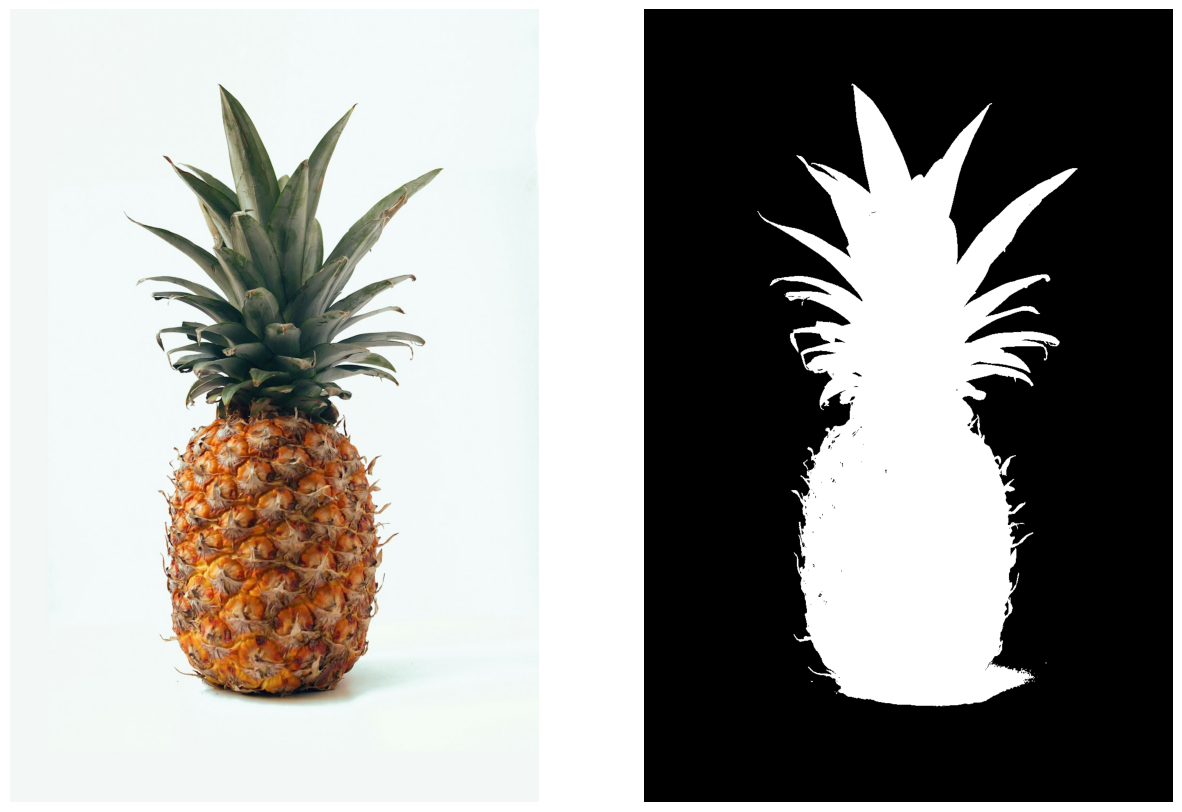

In [4]:
pineapple = cv2.cvtColor(cv2.imread(rf"Data/pineapple.png"), cv2.COLOR_BGR2RGB)
binary_pineapple = np.where(cv2.cvtColor(pineapple, cv2.COLOR_RGB2GRAY) > 230, 0, 1)

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(pineapple)
ax[1].imshow(binary_pineapple, cmap='gray')

ax[0].axis('off')
ax[1].axis('off')

This next example of a [butterfly](https://www.pngrepo.com/png/256208/512/butterfly.png) is ideal as it has no noise, meaning it will be easily converted into a binary image!

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

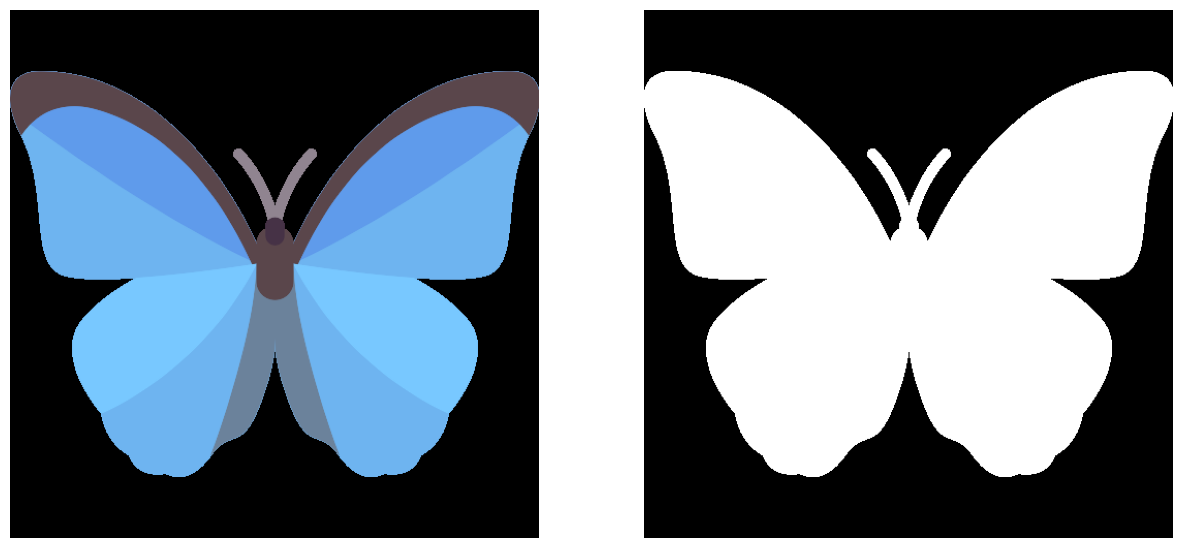

In [5]:
butterfly = cv2.cvtColor(cv2.imread(rf'Data/butterfly.png'), cv2.COLOR_BGR2RGB)
binary_butterfly = np.where(cv2.cvtColor(butterfly, cv2.COLOR_RGB2GRAY) > 0, 1, 0)

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(butterfly)
ax[1].imshow(binary_butterfly, cmap='gray')

ax[0].axis('off')
ax[1].axis('off')

### Segmenting Binary Images
In this part of the notebook, I'll go through 2 different methods for labeling connected components

The first method is using the **Region Growing Algorithm**, a method based mostly on DFS (from what I can tell). It's as follows:
1. Find unlabeled "seed" point with value = 1
    - if such a point does not exist, *end*
2. Assign label to seed
3. Assign sam label to all neighbors of seed w/ value = 1(DFS)
4. Repeat Step 3 until there are no more valid neighbors
5. Go to Step 1

In [6]:
def region_growing_alg(image):
    labels = set()
    labeled = np.zeros_like(image)
    visited = set()
    n, m = image.shape

    def dfs(i, j, label):
        """ Labels all valid neighbors"""
        
        labeled[i, j] = label
        visited.add((i, j))

        for x, y in [(i + 1 , j), (i , j + 1), (i - 1 , j), (i , j - 1)]:
            if (0 <= x < n and 0 <= y < m and (x, y) not in visited 
                and image[x, y] == 1):
                dfs(x, y, label)

    label = 0
    for i in range(n):
        for j in range(m):
            if (i, j) not in visited and image[i, j] == 1:
                label += 1
                labels.add(label)
                dfs(i, j, label)

    return labels, labeled
        


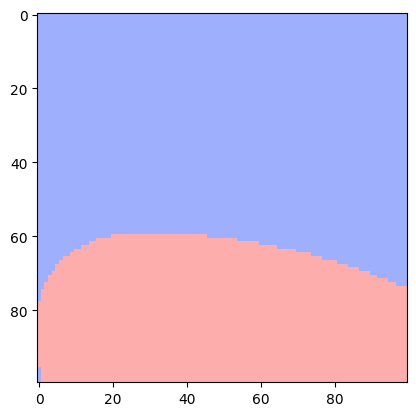

In [7]:
labels, labeled = region_growing_alg(binary_butterfly[:100, :100])
plt.imshow(labeled, cmap="berlin")

This case is almost too simple as there's only 1 object, however the algorithm will handle as many labels as necessary. The main complication actually arises in the size limitation. Even segmenting just the butterfly causes memory issues as the recursive stack gets too large.

Instead a BFS iterative approach will work better. Below is a modified version of the function above. As you can see, this time we can segment out the entire butterfly!

In [8]:
def region_grow_bfs(image):
    labels = set()
    labeled = np.zeros_like(image)
    visited = set()
    n, m = image.shape

    def bfs(i, j, label):
        """ Labels all valid neighbors"""
        
        queue = deque()
        queue.append((i, j))

        while(queue):
            curr_i, curr_j = queue.popleft()
            labeled[curr_i, curr_j] = label
            visited.add((curr_i, curr_j)) # redundant but secure

            for x, y in [(curr_i + 1 , curr_j), (curr_i , curr_j + 1), (curr_i - 1 , curr_j), (curr_i , curr_j - 1)]:
                if (0 <= x < n and 0 <= y < m and (x, y) not in visited and image[x, y] == 1):
                    visited.add((x, y)) # can't forget to add stuff before it goes into the queue!
                    queue.append((x, y))


    label = 0
    for i in range(n):
        for j in range(m):
            if (i, j) not in visited and image[i, j] == 1:
                label += 1
                labels.add(label)
                bfs(i, j, label)

    return labels, labeled

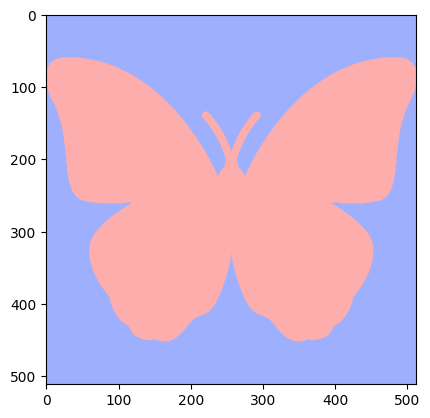

In [9]:
labels, labeled = region_grow_bfs(binary_butterfly)
plt.imshow(labeled, cmap="berlin")

In [10]:
from skimage import data
blobs = np.where(data.binary_blobs() == True, 1, 0)
blob_labels, blob_labeled = region_grow_bfs(blobs)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

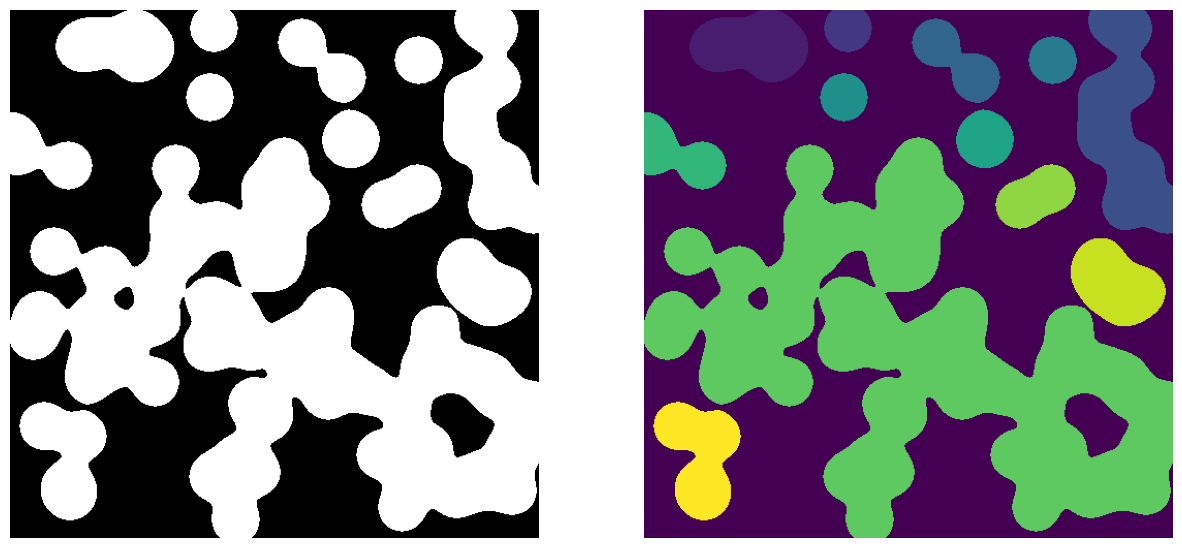

In [11]:
label_colors = {l:(255/len(blob_labels) *i + 20) for i, l in enumerate(list(blob_labels))}
blob_colored = blob_labeled.copy()
for l, v in label_colors.items():
    blob_colored[blob_colored == l] = v

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(blobs, cmap='gray')
ax[1].imshow(blob_colored)

ax[0].axis('off')
ax[1].axis('off')

The examples above use 4-Connectedness to define neighbors. Unfortunately neither 4-C nor 8-C preserves Jordan's Curve Theorem for creating 2 connected regions when segmenting something with a closed curve. For example:

$\begin{bmatrix}0 &1 &0\\1 &0 &1\\0 &1 &0 \end{bmatrix}$ => $\begin{bmatrix}B1 &O1 &B1\\O2 &B2 &04\\B1 &O4 & B1 \end{bmatrix}$ => $\begin{bmatrix}B &O &B\\ O &B &O\\ B &O &B \end{bmatrix}$

4-C (middle) shows that each object is separate and there's a hole, namely B2, in the middle

8-C (right) shows that although all objects are connected, there's a hole in the middle again

-----

*Instead* we'll opt to use 6-C! It introduces asymmetry to look more like a hexagon. We can use a Sequential Labeling Algorithm with Raster Scanning to efficiently handle edge cases. In this case, we assume B, C, D are labeled and assign A to a label accordingly.

$\begin{bmatrix}D &B\\C &A \end{bmatrix}$

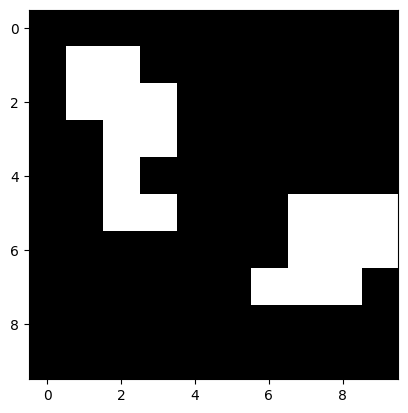

In [13]:
small_blob_1 = np.array([
    [0 , 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0 , 1, 1, 0, 0, 0, 0, 0, 0, 0], 
    [0 , 1, 1, 1, 0, 0, 0, 0, 0, 0], 
    [0 , 0, 1, 1, 0, 0, 0, 0, 0, 0], 
    [0 , 0, 1, 0, 0, 0, 0, 0, 0, 0], 
    [0 , 0, 1, 1, 0, 0, 0, 1, 1, 1], 
    [0 , 0, 0, 0, 0, 0, 0, 1, 1, 1], 
    [0 , 0, 0, 0, 0, 0, 1, 1, 1, 0], 
    [0 , 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0 , 0, 0, 0, 0, 0, 0, 0, 0, 0]
])
plt.imshow(small_blob_1, cmap='gray')

In [16]:
def seq_label_alg(image):
    labeled = np.zeros_like(image)
    equiv_table = {0:0}
    label = 1
    n, m = image.shape

    def valid_pos(i, j):
        return 0<=i<n and 0<=j<m
    
    def find(a):
        if equiv_table[a] != a:
            equiv_table[a] = find(equiv_table[a])
        return equiv_table[a]
    
    def union(a, b):
        a_parent = find(a)
        b_parent = find(b)
        if a_parent == b_parent:
            return
        elif a_parent < b_parent:
            equiv_table[b_parent] = a_parent
            return
        else:
            equiv_table[a_parent] = b_parent

        
    for i in range(n):
        for j in range(m):
            if image[i,j] != 0:
                # check pos D
                if valid_pos(i-1,j-1) and labeled[i-1, j-1]:
                    labeled[i, j] = labeled[i-1, j-1]

                elif (valid_pos(i-1, j) and labeled[i-1, j] and
                      valid_pos(i, j - 1) and labeled[i, j - 1]):
                    labeled[i, j] = min(labeled[i-1, j], labeled[i, j-1])
                    union(labeled[i-1, j], labeled[i, j-1])

                elif valid_pos(i-1, j) and labeled[i-1, j]:
                    labeled[i, j] = labeled[i-1, j]

                elif valid_pos(i, j - 1) and labeled[i, j - 1]:
                    labeled[i, j] = labeled[i, j - 1]
                
                else:
                    labeled[i, j] = label
                    equiv_table[label] = label
                    label += 1

    labels = set([0])
    for i in range(n):
        for j in range(m):
            labeled[i, j] = find(labeled[i, j])
            labels.add(labeled[i, j])

    return labels, labeled

In [17]:
l, ld = seq_label_alg(small_blob_1)

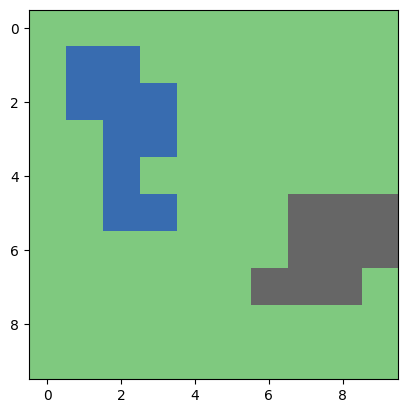

In [23]:
import binary_segmentation
plt.imshow(ld, cmap='Accent')

In [41]:
type(ld.ravel())

numpy.ndarray

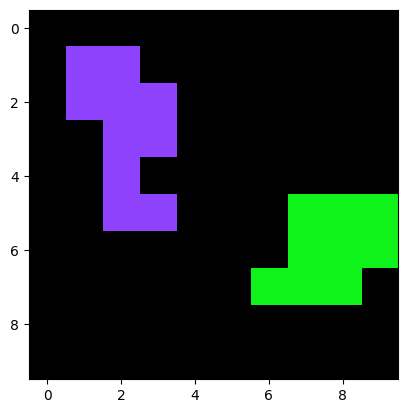

In [48]:
plt.imshow(binary_segmentation.color_segmentations(l, ld))

In [49]:
blob_seq_labels, blob_seq_labeled = seq_label_alg(blobs)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

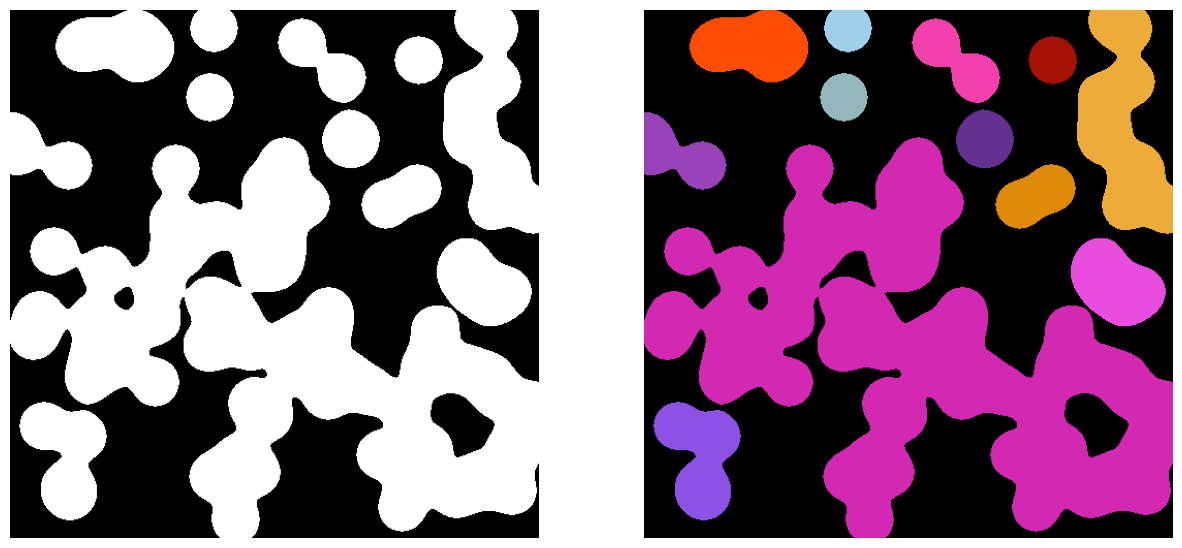

In [50]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(blobs, cmap='gray')
ax[1].imshow(binary_segmentation.color_segmentations(blob_seq_labels, blob_seq_labeled))

ax[0].axis('off')
ax[1].axis('off')